In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causallearn.search.ScoreBased.GES import ges
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from itertools import permutations
import pyEDM
import os
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from causallearn.search.FCMBased.lingam import VARLiNGAM

GES Method


--- Processing dataset: brownian-data-y1_0 ---
  Running GES...
  GES completed.


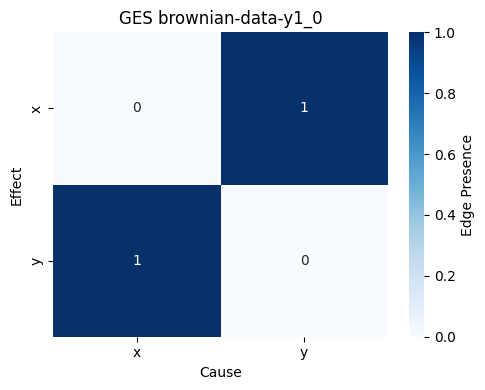


--- Causal Edges in brownian-data-y1_0 ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None

--- Done ---

--- Processing dataset: brownian-data-y2_0 ---
  Running GES...
  GES completed.


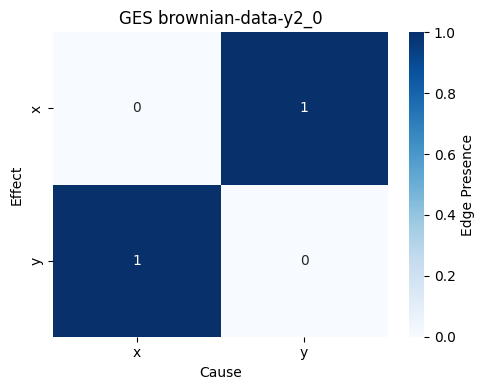


--- Causal Edges in brownian-data-y2_0 ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None

--- Done ---

--- Processing dataset: brownian-data-y3_0 ---
  Running GES...
  GES completed.


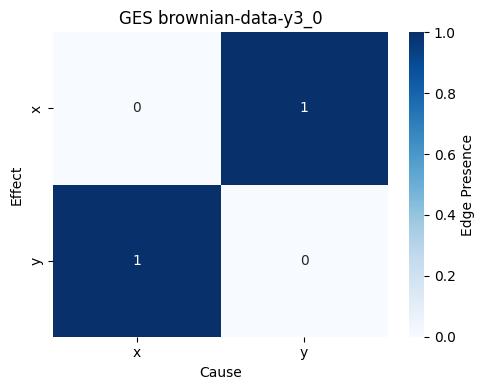


--- Causal Edges in brownian-data-y3_0 ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None

--- Done ---


In [ ]:
def compute_causal_graph_single_run(data_matrix, variable_names):
    """Compute causal graph using GES for a single run.

    Args:
        data_matrix (np.ndarray): 2D array of shape (n_samples, n_variables).
        variable_names (list[str]): List of variable names.

    Returns:
        tuple: A tuple containing:
            - directed_edges (list[tuple]): List of directed edges (source, target).
            - undirected_edges (list[tuple]): List of undirected edges as pairs.
    """
    cg_result = ges(data_matrix)
    cg = cg_result["G"]

    edges_directed = []
    edges_undirected = []

    for edge in cg.get_graph_edges():
        n1_idx = int(edge.get_node1().get_name()[1:]) - 1
        n2_idx = int(edge.get_node2().get_name()[1:]) - 1

        if 0 <= n1_idx < len(variable_names) and 0 <= n2_idx < len(variable_names):
            n1 = variable_names[n1_idx]
            n2 = variable_names[n2_idx]

            ep1, ep2 = edge.get_endpoint1(), edge.get_endpoint2()
            if ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
                edges_directed.append((n1, n2))
            elif ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
                edges_directed.append((n2, n1))
            else:
                edges_undirected += [(n1, n2), (n2, n1)]
        else:
            print(f"Warning: Invalid index in edge: {n1_idx}, {n2_idx}")

    return edges_directed, edges_undirected


def create_adjacency_matrix(directed_edges, undirected_edges, node_names):
    """Convert edge lists into an adjacency matrix.

    Args:
        directed_edges (list[tuple]): List of directed edges (source, target).
        undirected_edges (list[tuple]): List of undirected edges as pairs.
        node_names (list[str]): List of variable names.

    Returns:
        np.ndarray: Adjacency matrix of shape (n_nodes, n_nodes).
    """
    n = len(node_names)
    matrix = np.zeros((n, n))

    # Fill directed edges
    for src, tgt in directed_edges:
        if src in node_names and tgt in node_names:
            i, j = node_names.index(src), node_names.index(tgt)
            matrix[i, j] = 1

    # Fill undirected edges (symmetric)
    for src, tgt in undirected_edges:
        if src in node_names and tgt in node_names:
            i, j = node_names.index(src), node_names.index(tgt)
            matrix[i, j] = matrix[j, i] = 1

    return matrix


def plot_heatmap(matrix, algo_name, var_names, title_suffix=""):
    """Plot a heatmap for the adjacency matrix.

    Args:
        matrix (np.ndarray): Adjacency matrix.
        algo_name (str): Name of the causal discovery algorithm.
        var_names (list[str]): List of variable names.
        title_suffix (str, optional): Additional text for the title. Defaults to "".
    """
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=var_names, yticklabels=var_names,
                cbar_kws={'label': 'Edge Presence'})
    plt.title(f"{algo_name} {title_suffix}")
    plt.xlabel("Cause")
    plt.ylabel("Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


def process_file(file_path, file_label, variable_names):
    """Process a single dataset file using GES and plot adjacency matrix.

    Args:
        file_path (str): Path to the dataset file.
        file_label (str): Label for the dataset.
        variable_names (list[str]): List of variable names.
    """
    print(f"\n--- Processing dataset: {file_label} ---")
    
    # Load dataset and remove the first column (time index)
    data = np.loadtxt(file_path)
    data = data[:, 1:]  

    # Compute causal graph
    print("  Running GES...")
    directed, undirected = compute_causal_graph_single_run(data, variable_names)
    print("  GES completed.")

    # Convert edges to adjacency matrix and plot
    adj_mat = create_adjacency_matrix(directed, undirected, variable_names)
    plot_heatmap(adj_mat, "GES", variable_names, file_label)

    # Print edges
    print(f"\n--- Causal Edges in {file_label} ---")
    
    print("\n=== Directed Edges ===")
    if directed:
        for edge in sorted(set(directed)):
            print(f"{edge[0]} → {edge[1]}")
    else:
        print("None")

    print("\n=== Undirected Edges ===")
    undirected_only = {tuple(sorted((a, b))) for (a, b) in undirected
                       if (a, b) not in directed and (b, a) not in directed}
    if undirected_only:
        for edge in sorted(undirected_only):
            print(f"{edge[0]} — {edge[1]}")
    else:
        print("None")

    print("\n=== Bidirectional Edges ===")
    bidirectional = {tuple(sorted((a, b))) for (a, b) in directed
                     if (b, a) in directed}
    if bidirectional:
        for edge in sorted(bidirectional):
            print(f"{edge[0]} ↔ {edge[1]}")
    else:
        print("None")

    print("\n--- Done ---")


# === Main Execution ===
if __name__ == "__main__":
    variable_names = ['x', 'y']
    dataset_list = [
        ("./dataset/brownian-data-y1_0.dat", "brownian-data-y1_0"),
        ("./dataset/brownian-data-y2_0.dat", "brownian-data-y2_0"),
        ("./dataset/brownian-data-y3_0.dat", "brownian-data-y3_0")
    ]

    for file_path, label in dataset_list:
        process_file(file_path, label, variable_names)


PC Method


--- Processing dataset: brownian-data-y1_0.dat ---


Depth=0, working on node 1: 100%|██████████| 2/2 [00:00<00:00, 1757.88it/s]


=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None
--- Done ---


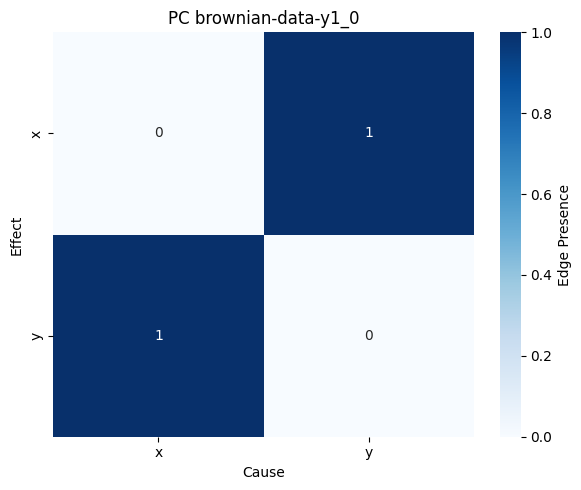


--- Processing dataset: brownian-data-y2_0.dat ---


Depth=0, working on node 1: 100%|██████████| 2/2 [00:00<00:00, 1885.08it/s]


=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None
--- Done ---


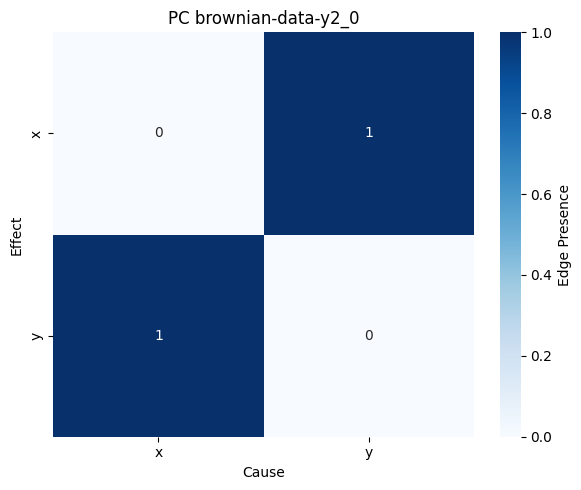


--- Processing dataset: brownian-data-y3_0.dat ---


Depth=0, working on node 1: 100%|██████████| 2/2 [00:00<00:00, 1736.05it/s]



=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None
--- Done ---


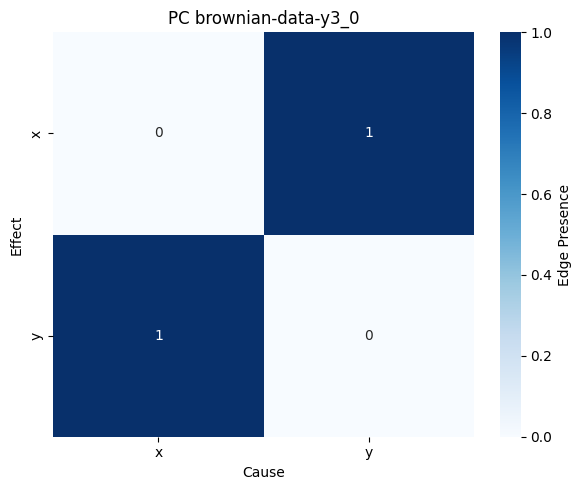

In [ ]:
# === Function definitions ===

def compute_causal_graph(data, var_names):
    """Compute the causal graph using the PC algorithm.

    Args:
        data (np.ndarray): Input data matrix of shape (n_samples, n_variables).
        var_names (list[str]): List of variable names corresponding to columns in data.

    Returns:
        tuple: Two lists of edges:
            - directed (list[tuple[str, str]]): List of directed edges (cause → effect).
            - undirected (list[tuple[str, str]]): List of undirected edges (variable1 — variable2).
    """
    cg = pc(data, alpha=0.05, indep_test=fisherz)
    directed = []
    undirected = []

    for edge in cg.G.get_graph_edges():
        n1_idx = int(edge.get_node1().get_name()[1:]) - 1
        n2_idx = int(edge.get_node2().get_name()[1:]) - 1
        if n1_idx >= len(var_names) or n2_idx >= len(var_names):
            continue
        n1 = var_names[n1_idx]
        n2 = var_names[n2_idx]

        ep1 = edge.get_endpoint1()
        ep2 = edge.get_endpoint2()

        if ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
            directed.append((n1, n2))
        elif ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
            directed.append((n2, n1))
        else:
            undirected.append((n1, n2))
            undirected.append((n2, n1))

    return directed, undirected


def create_frequency_matrix(directed, undirected, node_names):
    """Convert edge lists to a frequency adjacency matrix.

    Args:
        directed (list[tuple[str, str]]): Directed edges (cause → effect).
        undirected (list[tuple[str, str]]): Undirected edges (variable1 — variable2).
        node_names (list[str]): List of variable names (matrix row/column order).

    Returns:
        np.ndarray: Frequency adjacency matrix of shape (n_nodes, n_nodes).
    """
    n = len(node_names)
    mat = np.zeros((n, n), dtype=int)

    for i, j in directed:
        a = node_names.index(i)
        b = node_names.index(j)
        mat[a, b] += 1

    for i, j in undirected:
        a = node_names.index(i)
        b = node_names.index(j)
        mat[a, b] += 1

    return mat


def plot_heatmap(matrix, algo_name, var_names, title_suffix=""):
    """Plot a heatmap of the adjacency/frequency matrix.

    Args:
        matrix (np.ndarray): Adjacency or frequency matrix.
        algo_name (str): Name of the causal discovery algorithm.
        var_names (list[str]): List of variable names for axis labels.
        title_suffix (str, optional): Suffix to append to the plot title.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=var_names, yticklabels=var_names,
                cbar_kws={'label': 'Edge Presence'})
    plt.title(f"{algo_name} {title_suffix}")
    plt.xlabel("Cause")
    plt.ylabel("Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


def run_on_dataset(file_path, var_names):
    """Process a dataset: run PC algorithm, print edges, and plot heatmap.

    Args:
        file_path (str): Path to the input dataset file.
        var_names (list[str]): List of variable names to assign to columns.
    """
    print(f"\n--- Processing dataset: {file_path.split('/')[-1]} ---")

    # Load dataset
    df = pd.read_csv(file_path, header=None, sep=r'\s+')
    df = df.iloc[:, 1:]  # Skip first column if needed
    df.columns = var_names
    data = df.values

    # Compute causal edges
    directed_edges, undirected_edges = compute_causal_graph(data, var_names)
    matrix = create_frequency_matrix(directed_edges, undirected_edges, var_names)

    # Print results
    print("\n=== Directed Edges ===")
    if directed_edges:
        for e in sorted(set(directed_edges)):
            print(f"{e[0]} → {e[1]}")
    else:
        print("None")

    undir_set = set(frozenset((a, b)) for (a, b) in undirected_edges if a != b)
    print("\n=== Undirected Edges ===")
    if undir_set:
        for e in sorted(undir_set, key=lambda x: sorted(x)):
            a, b = sorted(e)
            print(f"{a} — {b}")
    else:
        print("None")

    print("\n=== Bidirectional Edges ===")
    bidir = set((a, b) for (a, b) in directed_edges if (b, a) in directed_edges)
    if bidir:
        for a, b in sorted(bidir):
            print(f"{a} ↔ {b}")
    else:
        print("None")

    print("--- Done ---")

    # Plot heatmap
    plot_heatmap(matrix, "PC", var_names, title_suffix=file_path.split("/")[-1].replace(".dat", ""))


# === Main execution ===

file_paths = [
    "./dataset/brownian-data-y1_0.dat",
    "./dataset/brownian-data-y2_0.dat",
    "./dataset/brownian-data-y3_0.dat"
]

variable_names = ['x', 'y']

for path in file_paths:
    run_on_dataset(path, variable_names)


CCM Method


--- Processing dataset: brownian-data-y1_0.dat ---

Potential causal edges (x → y) with rho > 0.2:
x → y (lag=11): rho = 0.997
y → x (lag=0): rho = 0.996


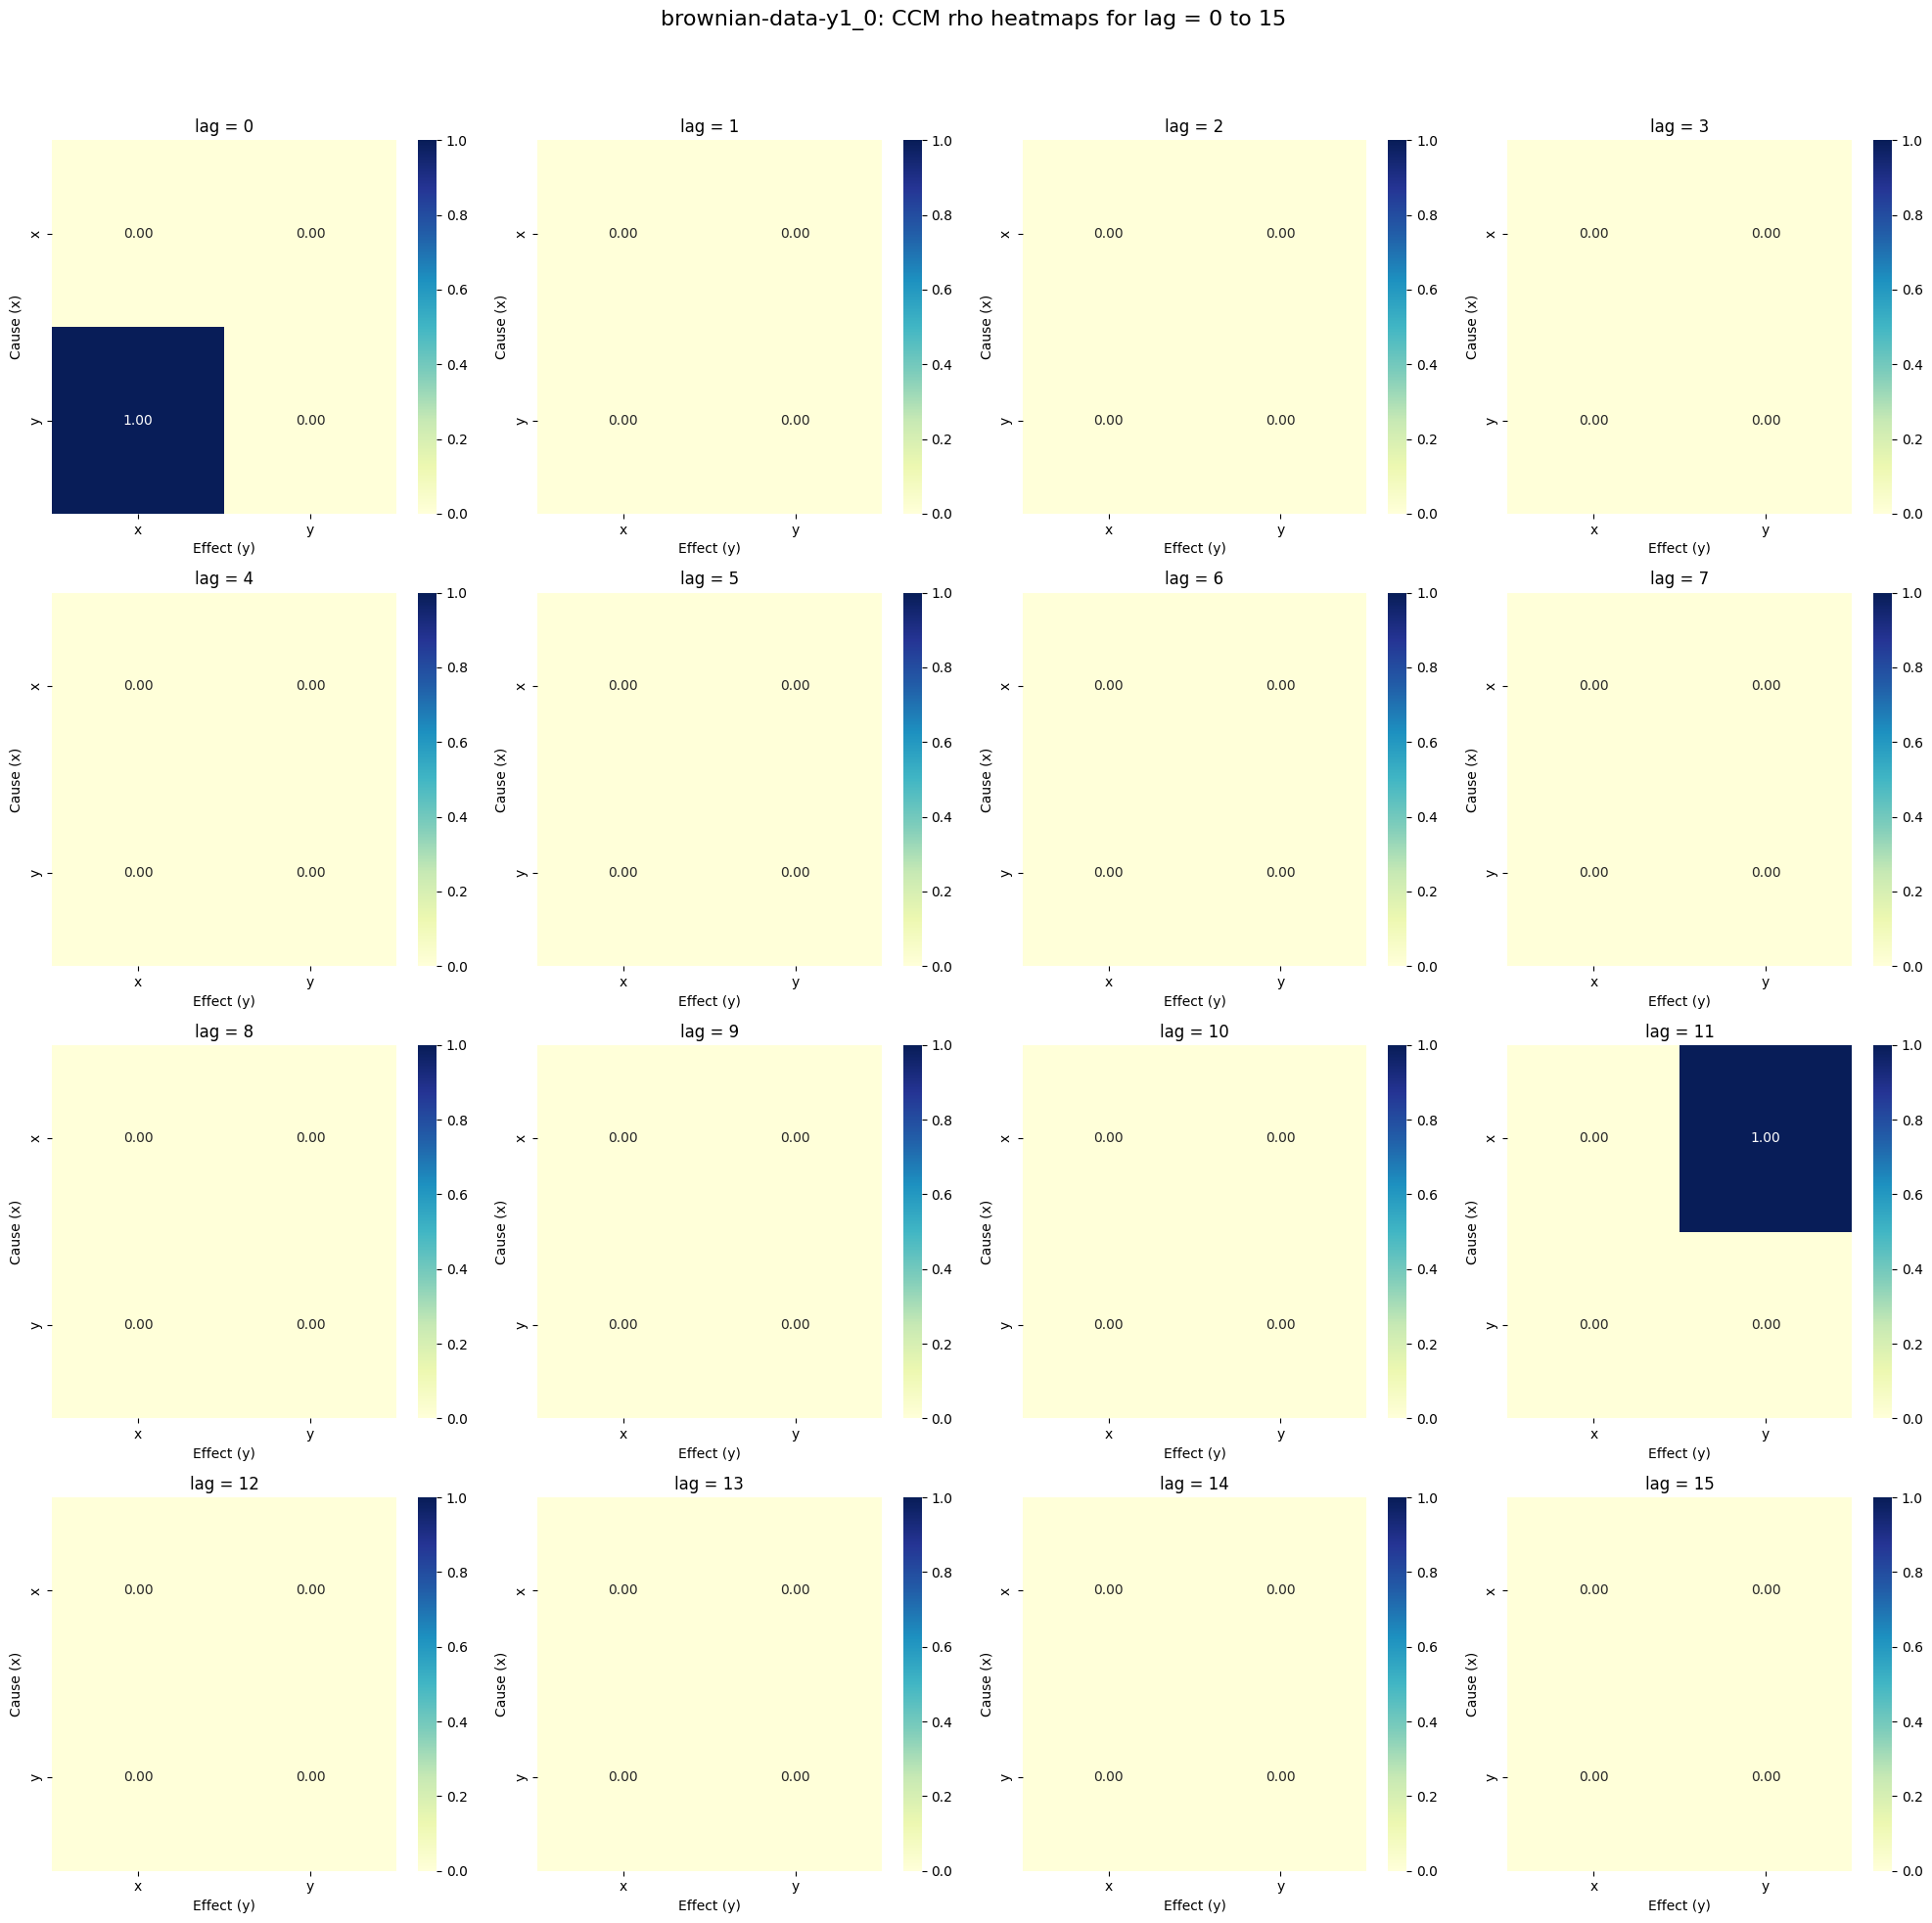

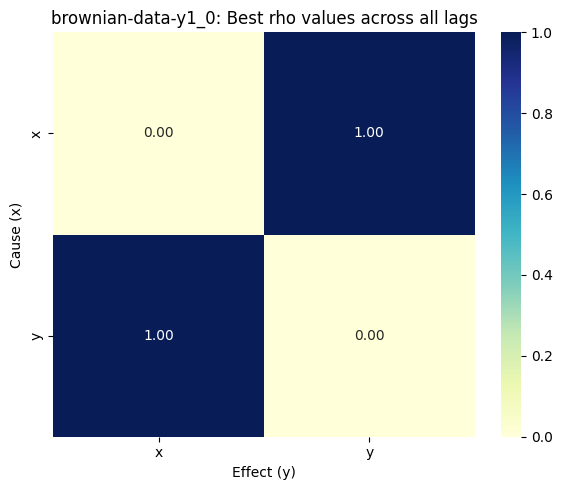


--- Processing dataset: brownian-data-y2_0.dat ---

Potential causal edges (x → y) with rho > 0.2:
x → y (lag=11): rho = 0.998
y → x (lag=3): rho = 0.762


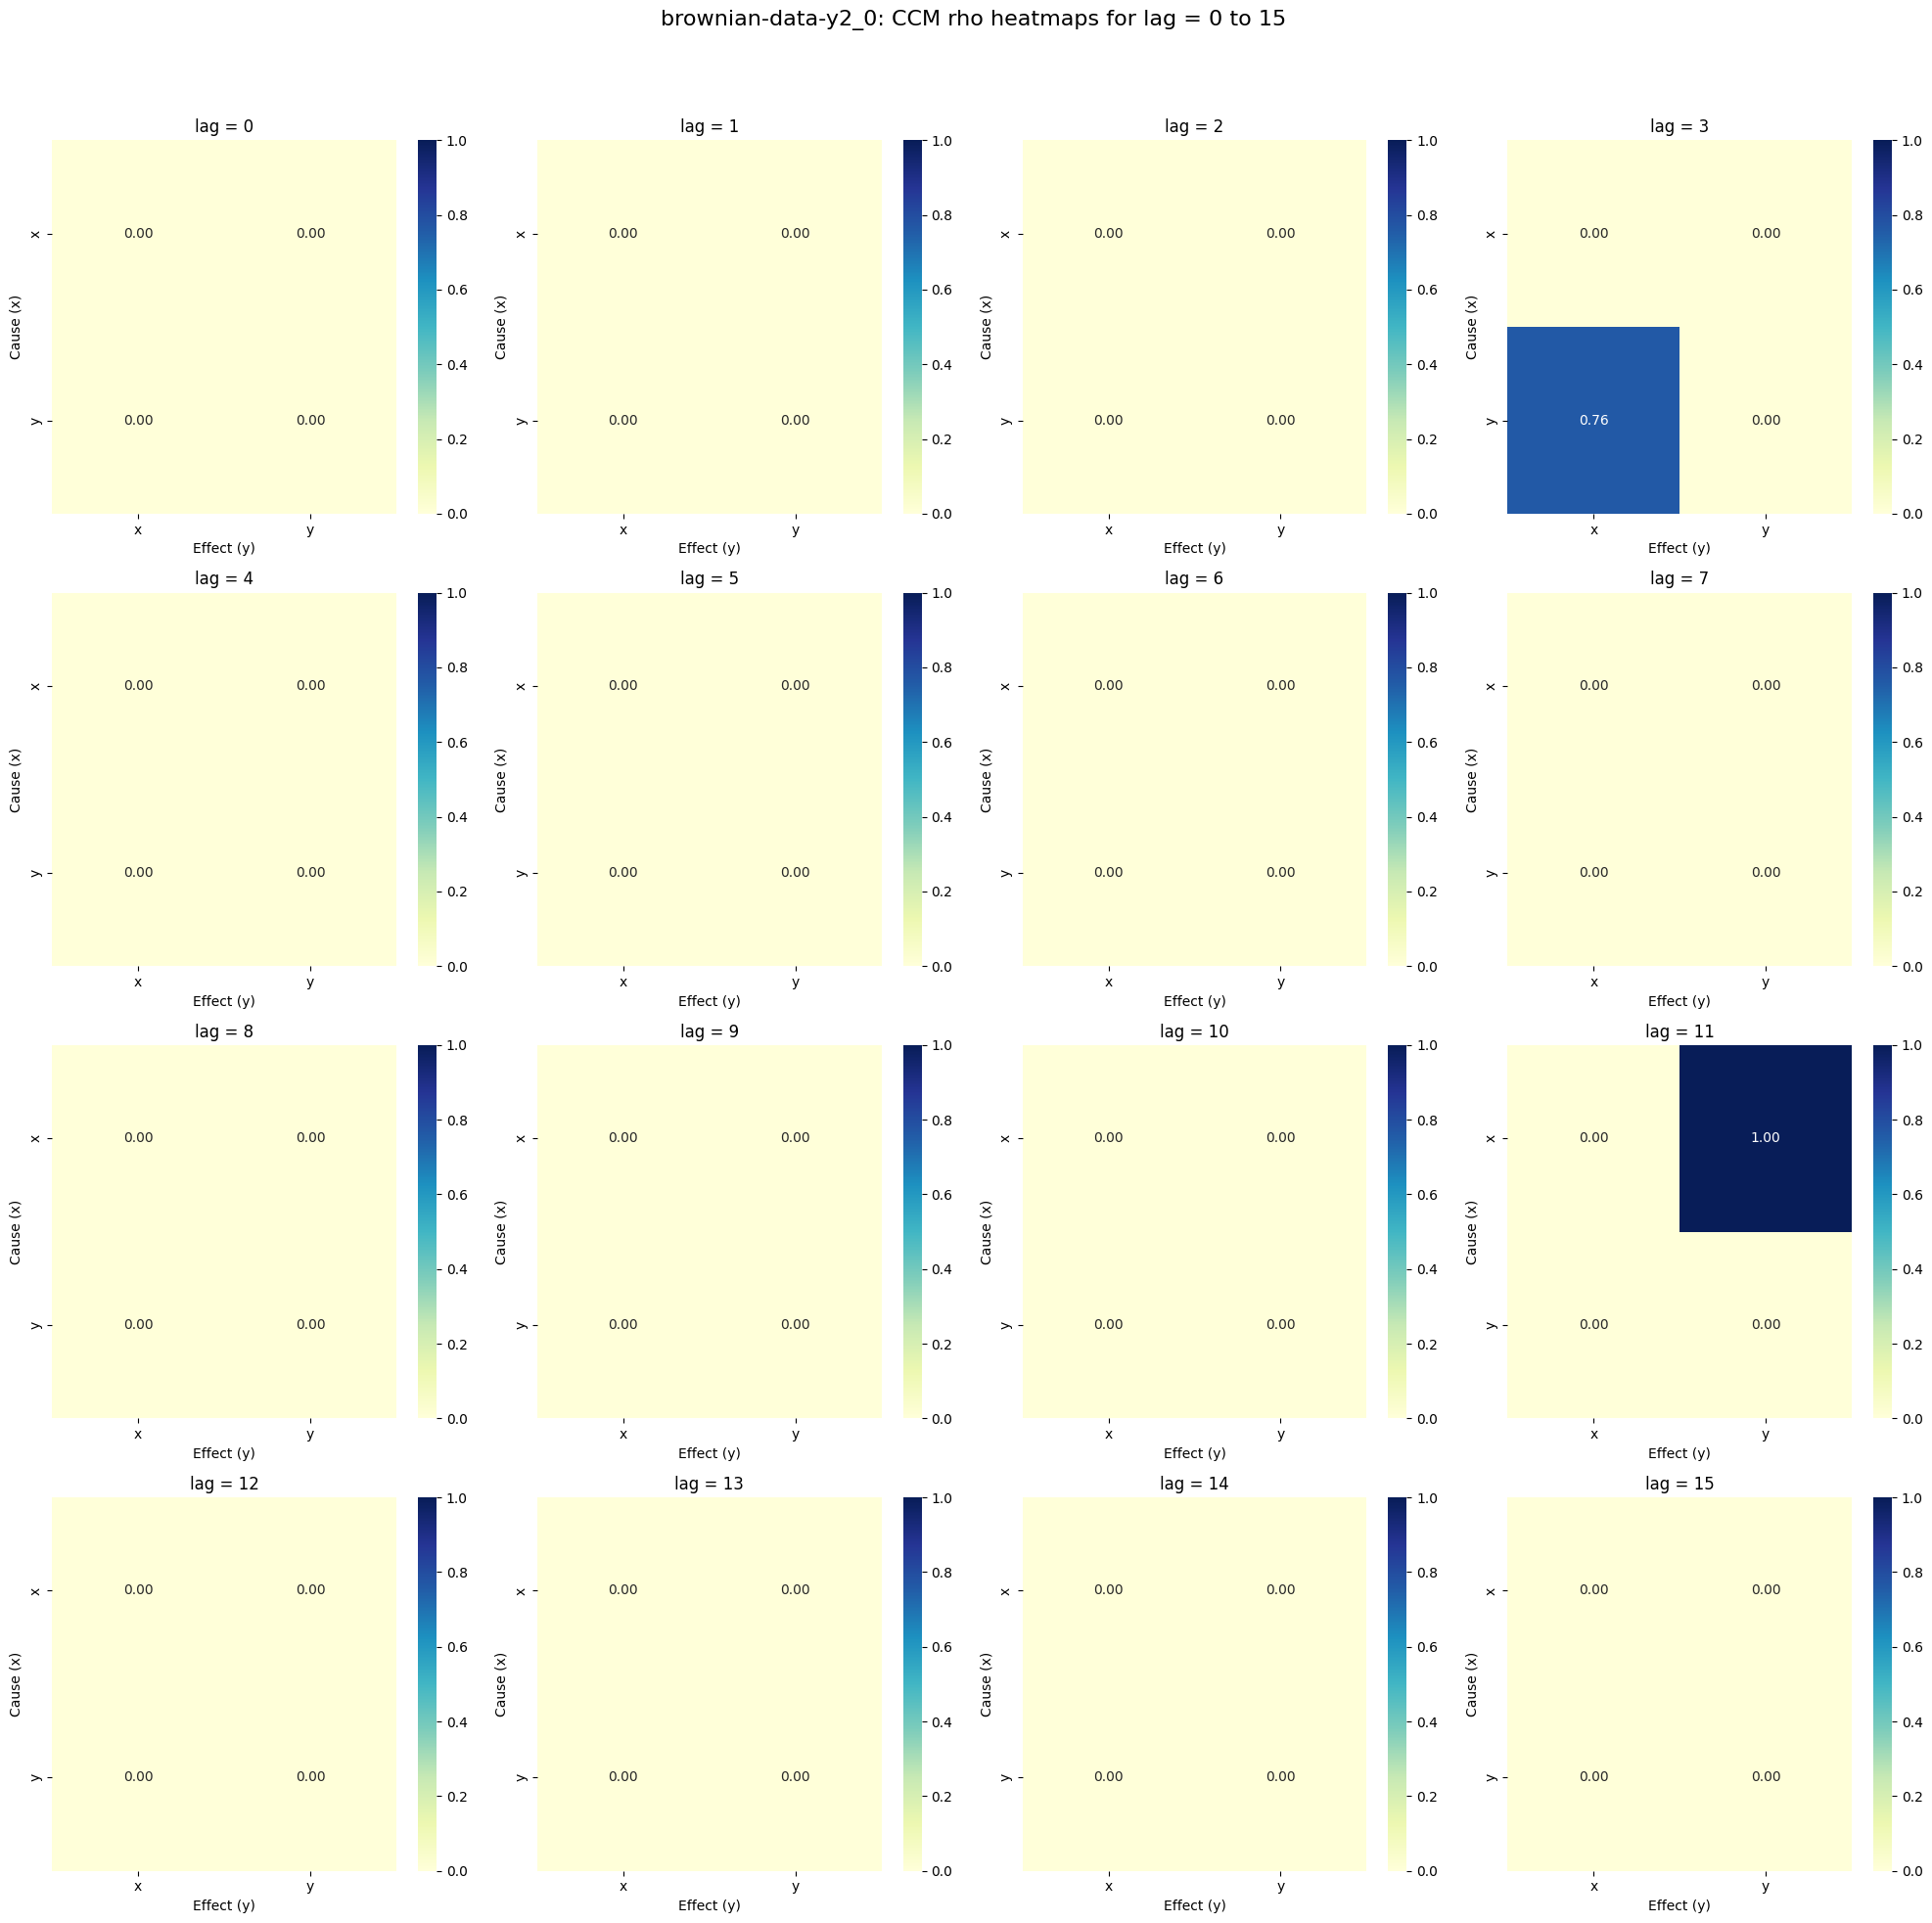

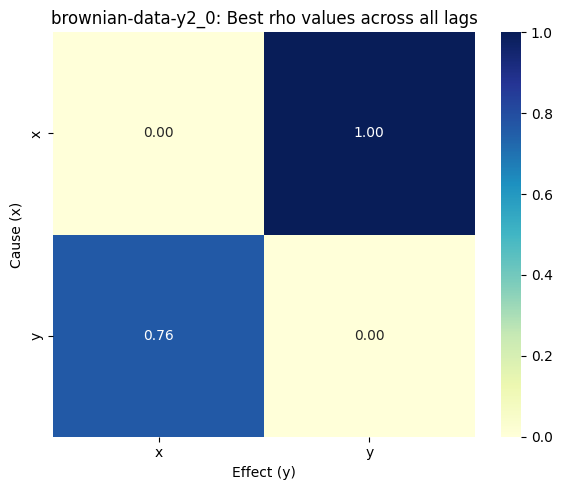


--- Processing dataset: brownian-data-y3_0.dat ---

Potential causal edges (x → y) with rho > 0.2:
x → y (lag=11): rho = 0.941


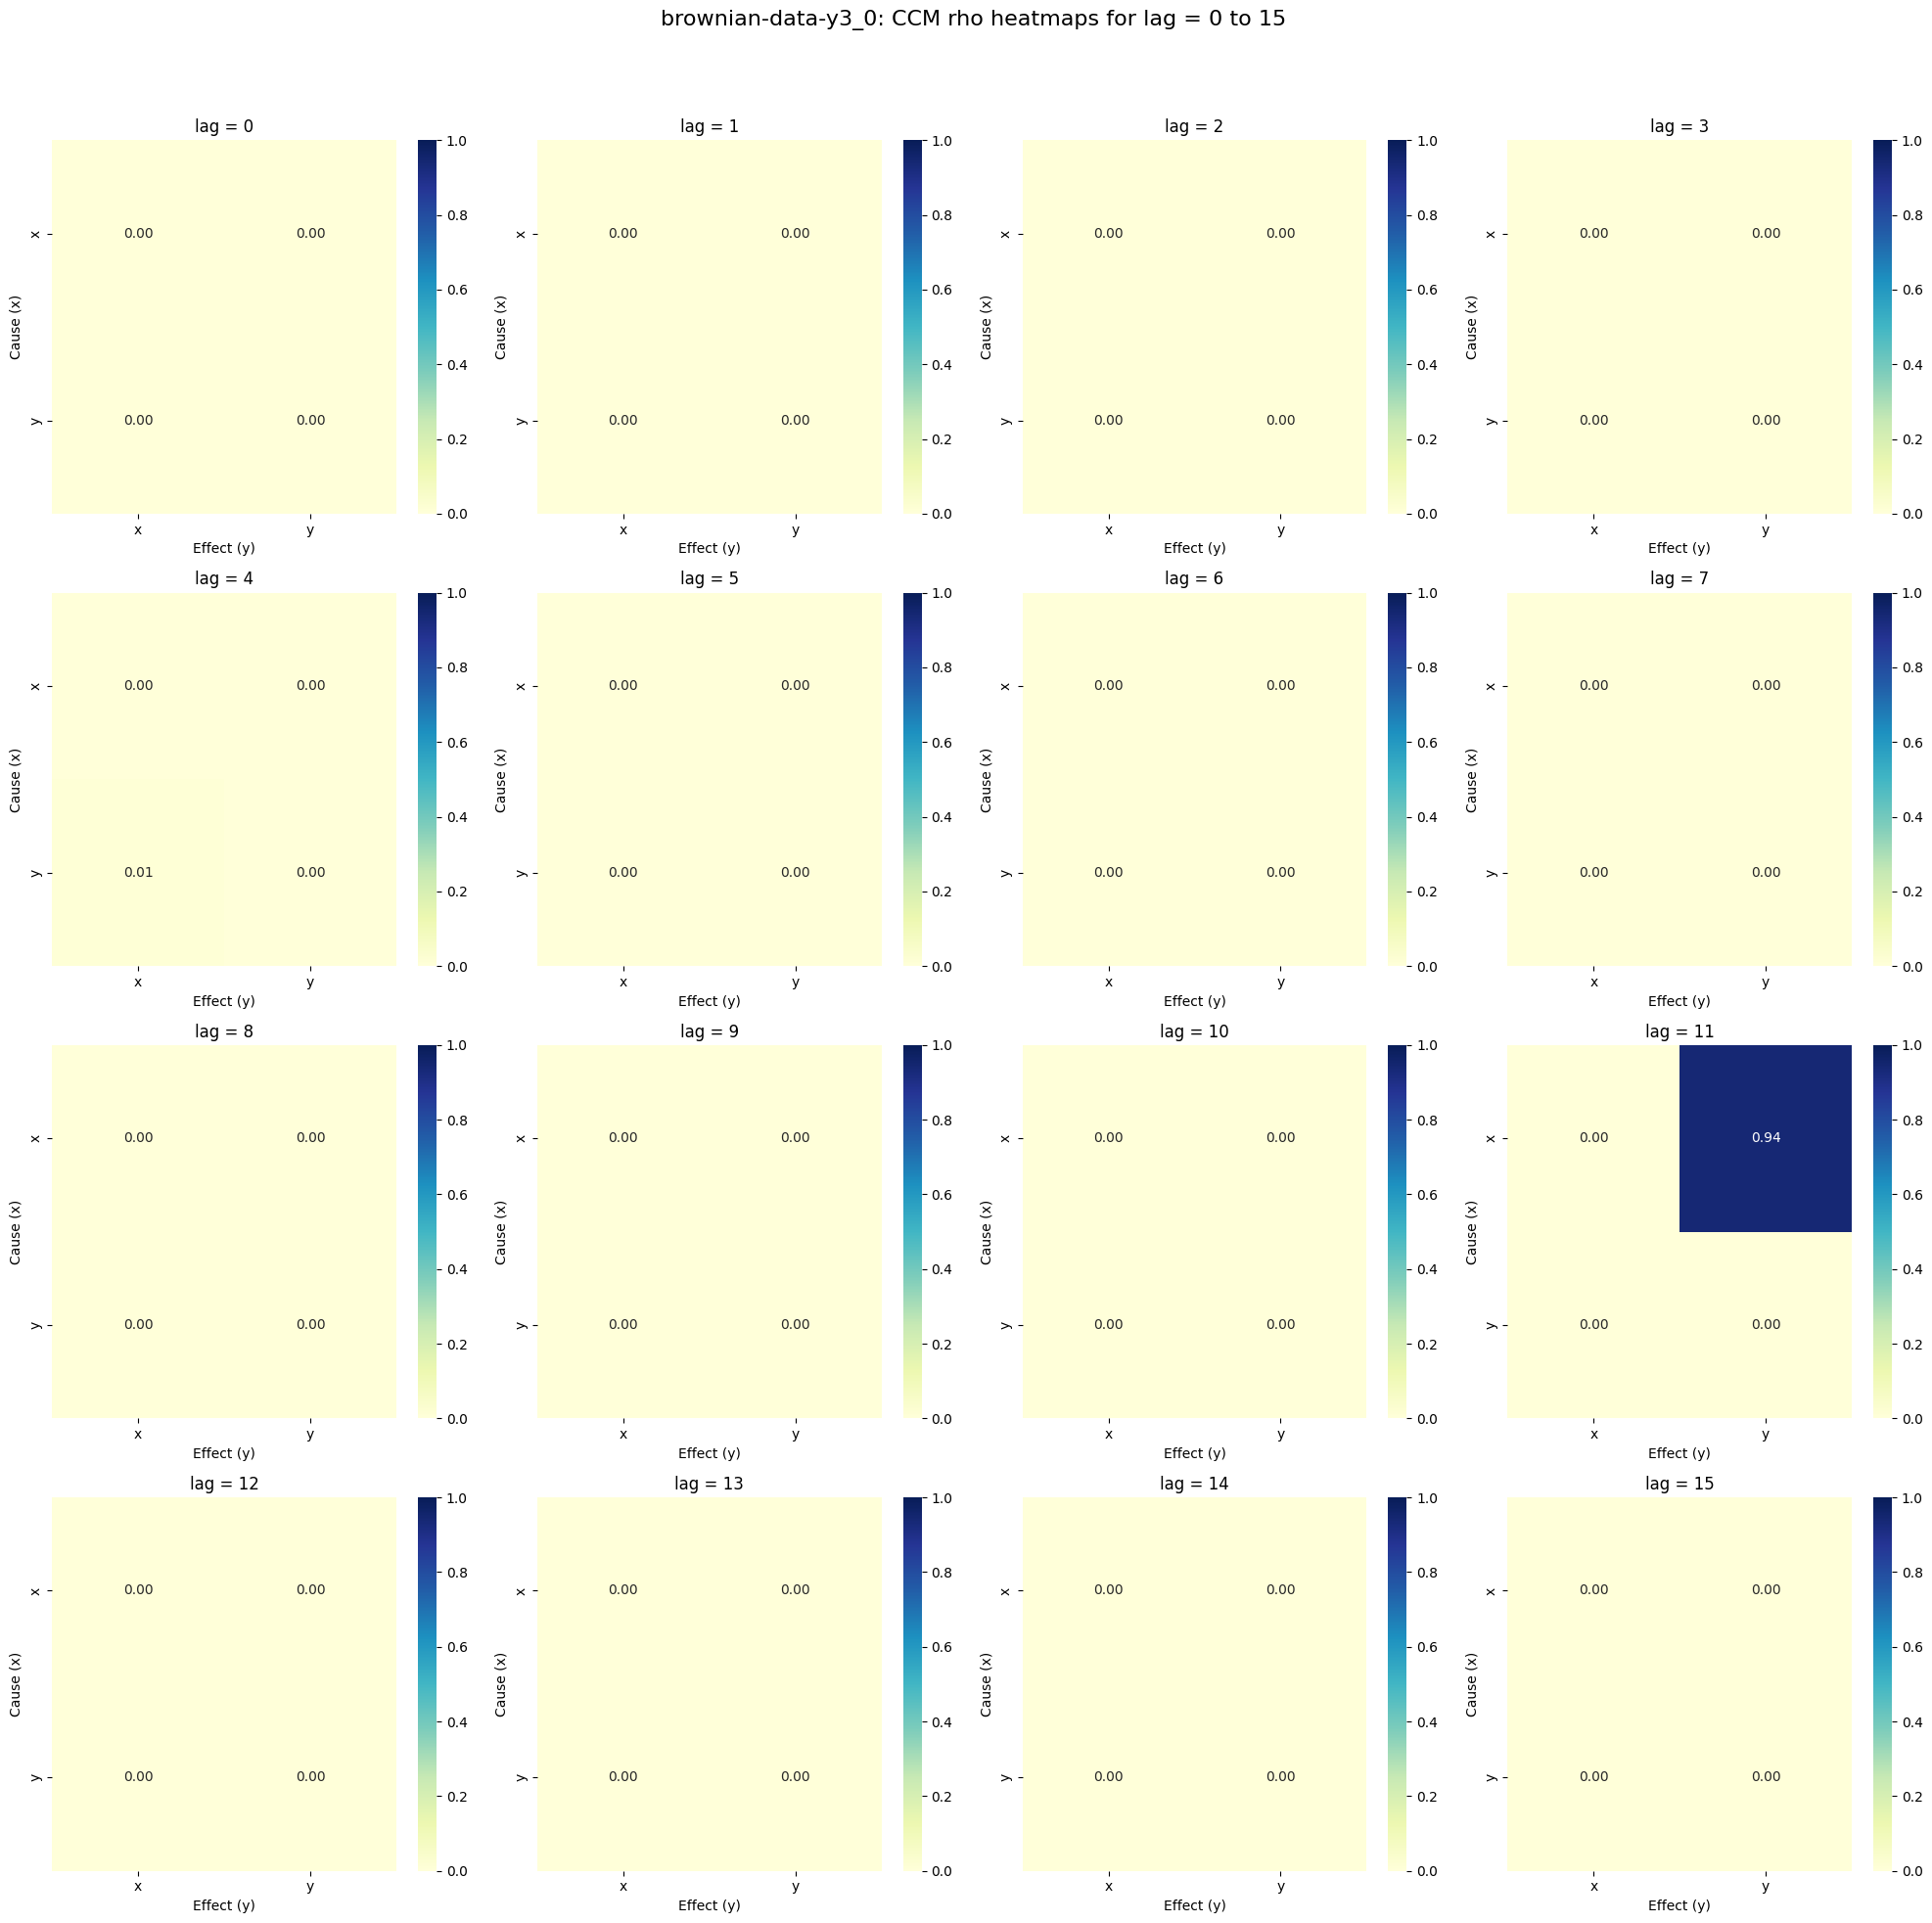

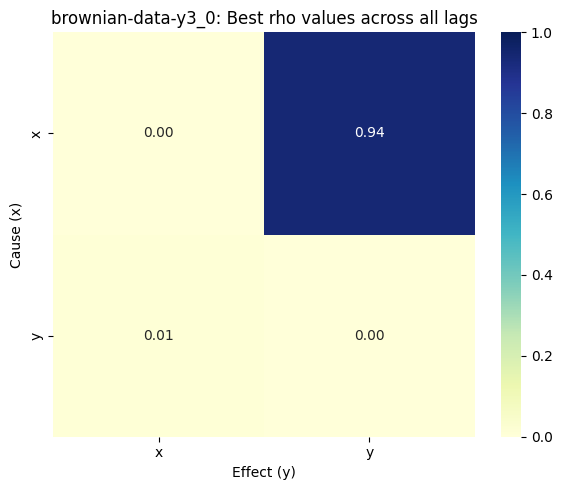


--- All dataset analyses complete! ---


In [ ]:
# --- Configuration ---
file_paths = [
    "./dataset/brownian-data-y1_0.dat",
    "./dataset/brownian-data-y2_0.dat",
    "./dataset/brownian-data-y3_0.dat"
]

threshold = 0.2
max_lag_to_test = 15
E = 2
libSizes = "20 80 20"
sample = 100

# --- Function Definitions ---
def compute_ccm_with_lag(x, y, E=2, libSizes="20 80 20", sample=100, max_lag=15):
    """Compute CCM (Convergent Cross Mapping) correlation values for multiple time lags.

    For each lag from 0 to `max_lag`, the target time series `y` is shifted and CCM is
    computed to measure causal influence from `x` to `y`.

    Args:
        x (array-like): Source time series.
        y (array-like): Target time series.
        E (int, optional): Embedding dimension. Defaults to 2.
        libSizes (str, optional): Library sizes for CCM. Defaults to "20 80 20".
        sample (int, optional): Number of samples per library size. Defaults to 100.
        max_lag (int, optional): Maximum time lag to test. Defaults to 15.

    Returns:
        list of tuple: List of `(lag, rho)` pairs, where `rho` is the CCM correlation value
        for the given lag.
    """
    results = []
    for lag in range(0, max_lag + 1):
        shifted_y = pd.Series(y).shift(-lag)
        df_ccm_aligned = pd.DataFrame({
            "time": np.arange(len(x)),
            "x": x,
            "y_shifted": shifted_y
        }).dropna().reset_index(drop=True)

        if df_ccm_aligned.empty:
            rho = np.nan
        else:
            try:
                result = pyEDM.CCM(
                    dataFrame=df_ccm_aligned,
                    E=E,
                    columns="x",
                    target="y_shifted",
                    libSizes=libSizes,
                    sample=sample,
                    embedded=True,
                    showPlot=False
                )
                rho = result["x:y_shifted"].values[-1]
            except Exception as e:
                print(f"Error in pyEDM.CCM for lag {lag}: {e}")
                rho = np.nan
        results.append((lag, rho))
    return results


# --- Main Loop over Datasets ---
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    print(f"\n--- Processing dataset: {file_name} ---")

    # Load dataset, skip the first column (timestep)
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, usecols=[1, 2])
    df.columns = ['x', 'y']
    variables = df.columns.tolist()
    n_vars = len(variables)

    causal_results = []

    # Compute CCM for all pairs of variables
    for i, j in permutations(range(n_vars), 2):
        source_var = variables[i]
        target_var = variables[j]
        x = df[source_var].values
        y = df[target_var].values

        lag_results = compute_ccm_with_lag(
            x, y, E=E, libSizes=libSizes, sample=sample, max_lag=max_lag_to_test
        )

        # Select best lag with maximum rho
        valid = [(lag, rho) for lag, rho in lag_results if not np.isnan(rho)]
        if valid:
            best_lag, best_rho = max(valid, key=lambda item: item[1])
        else:
            best_lag, best_rho = np.nan, np.nan

        causal_results.append((source_var, target_var, best_lag, best_rho))

    # --- Print Significant Results ---
    print(f"\nPotential causal edges (x → y) with rho > {threshold}:")
    significant_edges = [
        edge for edge in causal_results if not np.isnan(edge[3]) and edge[3] > threshold
    ]
    if significant_edges:
        for source, target, lag, rho in significant_edges:
            print(f"{source} → {target} (lag={int(lag)}): rho = {rho:.3f}")
    else:
        print("No significant causal edges found above the threshold.")

    # --- Plot CCM rho heatmaps for each lag ---
    cols = 4
    rows = (max_lag_to_test + 1 + cols - 1) // cols  # rows needed for all lags
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    for idx, lag in enumerate(range(0, max_lag_to_test + 1)):
        row_idx = idx // cols
        col_idx = idx % cols
        ax = axes[row_idx, col_idx]

        matrix = np.zeros((n_vars, n_vars))
        for source, target, best_lag, rho in causal_results:
            if not np.isnan(rho) and best_lag == lag:
                i = variables.index(source)
                j = variables.index(target)
                matrix[i, j] = rho

        sns.heatmap(
            matrix, annot=True, xticklabels=variables, yticklabels=variables,
            cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1, ax=ax
        )
        ax.set_title(f"lag = {lag}")
        ax.set_xlabel("Effect (y)")
        ax.set_ylabel("Cause (x)")

    # Turn off unused subplots
    for idx in range(max_lag_to_test + 1, rows * cols):
        row_idx = idx // cols
        col_idx = idx % cols
        fig.delaxes(axes[row_idx, col_idx])

    fig.suptitle(
        f"{file_name.replace('.dat', '')}: CCM rho heatmaps for lag = 0 to {max_lag_to_test}",
        fontsize=16
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    plt.close()

    # --- Plot best rho heatmap across all lags ---
    best_rho_matrix = np.zeros((n_vars, n_vars))
    for source, target, best_lag, best_rho in causal_results:
        if not np.isnan(best_rho):
            i = variables.index(source)
            j = variables.index(target)
            best_rho_matrix[i, j] = best_rho

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        best_rho_matrix, annot=True, xticklabels=variables, yticklabels=variables,
        cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1
    )
    plt.title(f"{file_name.replace('.dat', '')}: Best rho values across all lags")
    plt.xlabel("Effect (y)")
    plt.ylabel("Cause (x)")
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n--- All dataset analyses complete! ---")


Transfer Entropy

In [ ]:
# === Data file paths ===
file_paths = [
    "./dataset/brownian-data-y1_0.dat",
    "./dataset/brownian-data-y2_0.dat",
    "./dataset/brownian-data-y3_0.dat"
]

# === IDTxl settings ===
settings = {
    'cmi_estimator': 'JidtKraskovCMI',
    'max_lag_sources': 15,
    'min_lag_sources': 1,
    'verbosity': 0,
    'n_perm_max_stat': 100,
    'n_perm_omnibus': 100,
    'tau_min': 1,
    'tau_max': 1,
}

# === Process each dataset file ===
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    print(f"\n=== Processing dataset: {file_name} ===")

    # --- Load dataset ---
    # Reads the data file, skipping the first column (timestep), and assigns column names 'x' and 'y'.
    # If the file does not exist, prints a warning and skips to the next file.
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path, delim_whitespace=True, header=None, usecols=[1, 2])
    df.columns = ['x', 'y']

    # --- Subset data ---
    # Selects the first 2% of the dataset (or at least 10 samples) for faster analysis.
    # Prints the original length, subset size, and percentage used.
    n_total = df.shape[0]
    n_subset = max(10, int(n_total * 0.02))  # Use first 2% or at least 10 rows
    df_sub = df.iloc[:n_subset]
    print(f"Original length: {n_total}, Using first {n_subset} samples ({100*n_subset/n_total:.1f}%)")

    # --- Prepare data for IDTxl analysis ---
    # Converts the dataframe to a numpy array with shape [variables, time] for IDTxl.
    # 'dim_order' is set to 'ps', meaning 'variables x time series'.
    data_array = df_sub.values.T
    data = Data(data_array, dim_order='ps')

    # --- Run multivariate Transfer Entropy (TE) analysis ---
    # Initializes the MultivariateTE object and performs the TE network analysis with the specified settings.
    # The results contain the inferred causal relationships among variables in the subset.
    network_analysis = MultivariateTE()
    results = network_analysis.analyse_network(settings=settings, data=data)



=== Processing dataset: brownian-data-y1_0.dat ===
Original length: 100000, Using first 2000 samples (2.0%)
Adding data with properties: 2 processes, 2000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1]

Target: 0 - testing sources [1]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 100
testing candidate: (0, 12) maximum statistic, n_perm: 100
testing candidate: (0, 8) maximum statistic, n_perm: 100
testing candidate: (0, 5) maximum statistic, n_perm: 100
testing candidate: (0, 15) maximum statistic, n_perm: 100
testing candidate: (0, 9) maximum statistic, n_perm: 100
testing candidate: (0, 3) maximum statistic, n_perm: 100
testing candidate: (0, 10) maximum statistic, n_perm: 100
testing candidate: (0, 6) maximum statistic

VARLiNGAM


================== Analyzing brownian-data-y1_0.dat ==================

--- Causal Edges with Strength > 0.1 ---

Lag 0:
No strong causal edges.

Lag 1:
x(t-1) → x(t): strength = 1.002

Lag 2:
No strong causal edges.

Lag 3:
No strong causal edges.

Lag 4:
No strong causal edges.

Lag 5:
No strong causal edges.

Lag 6:
No strong causal edges.

Lag 7:
No strong causal edges.

Lag 8:
No strong causal edges.

Lag 9:
No strong causal edges.

Lag 10:
No strong causal edges.

Lag 11:
x(t-11) → y(t): strength = 1.000

Lag 12:
No strong causal edges.

Lag 13:
No strong causal edges.

Lag 14:
No strong causal edges.

Lag 15:
No strong causal edges.


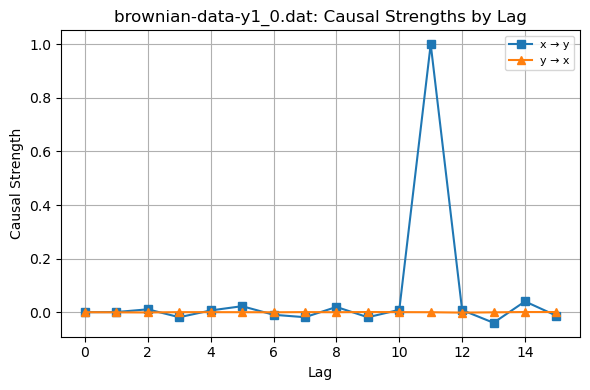

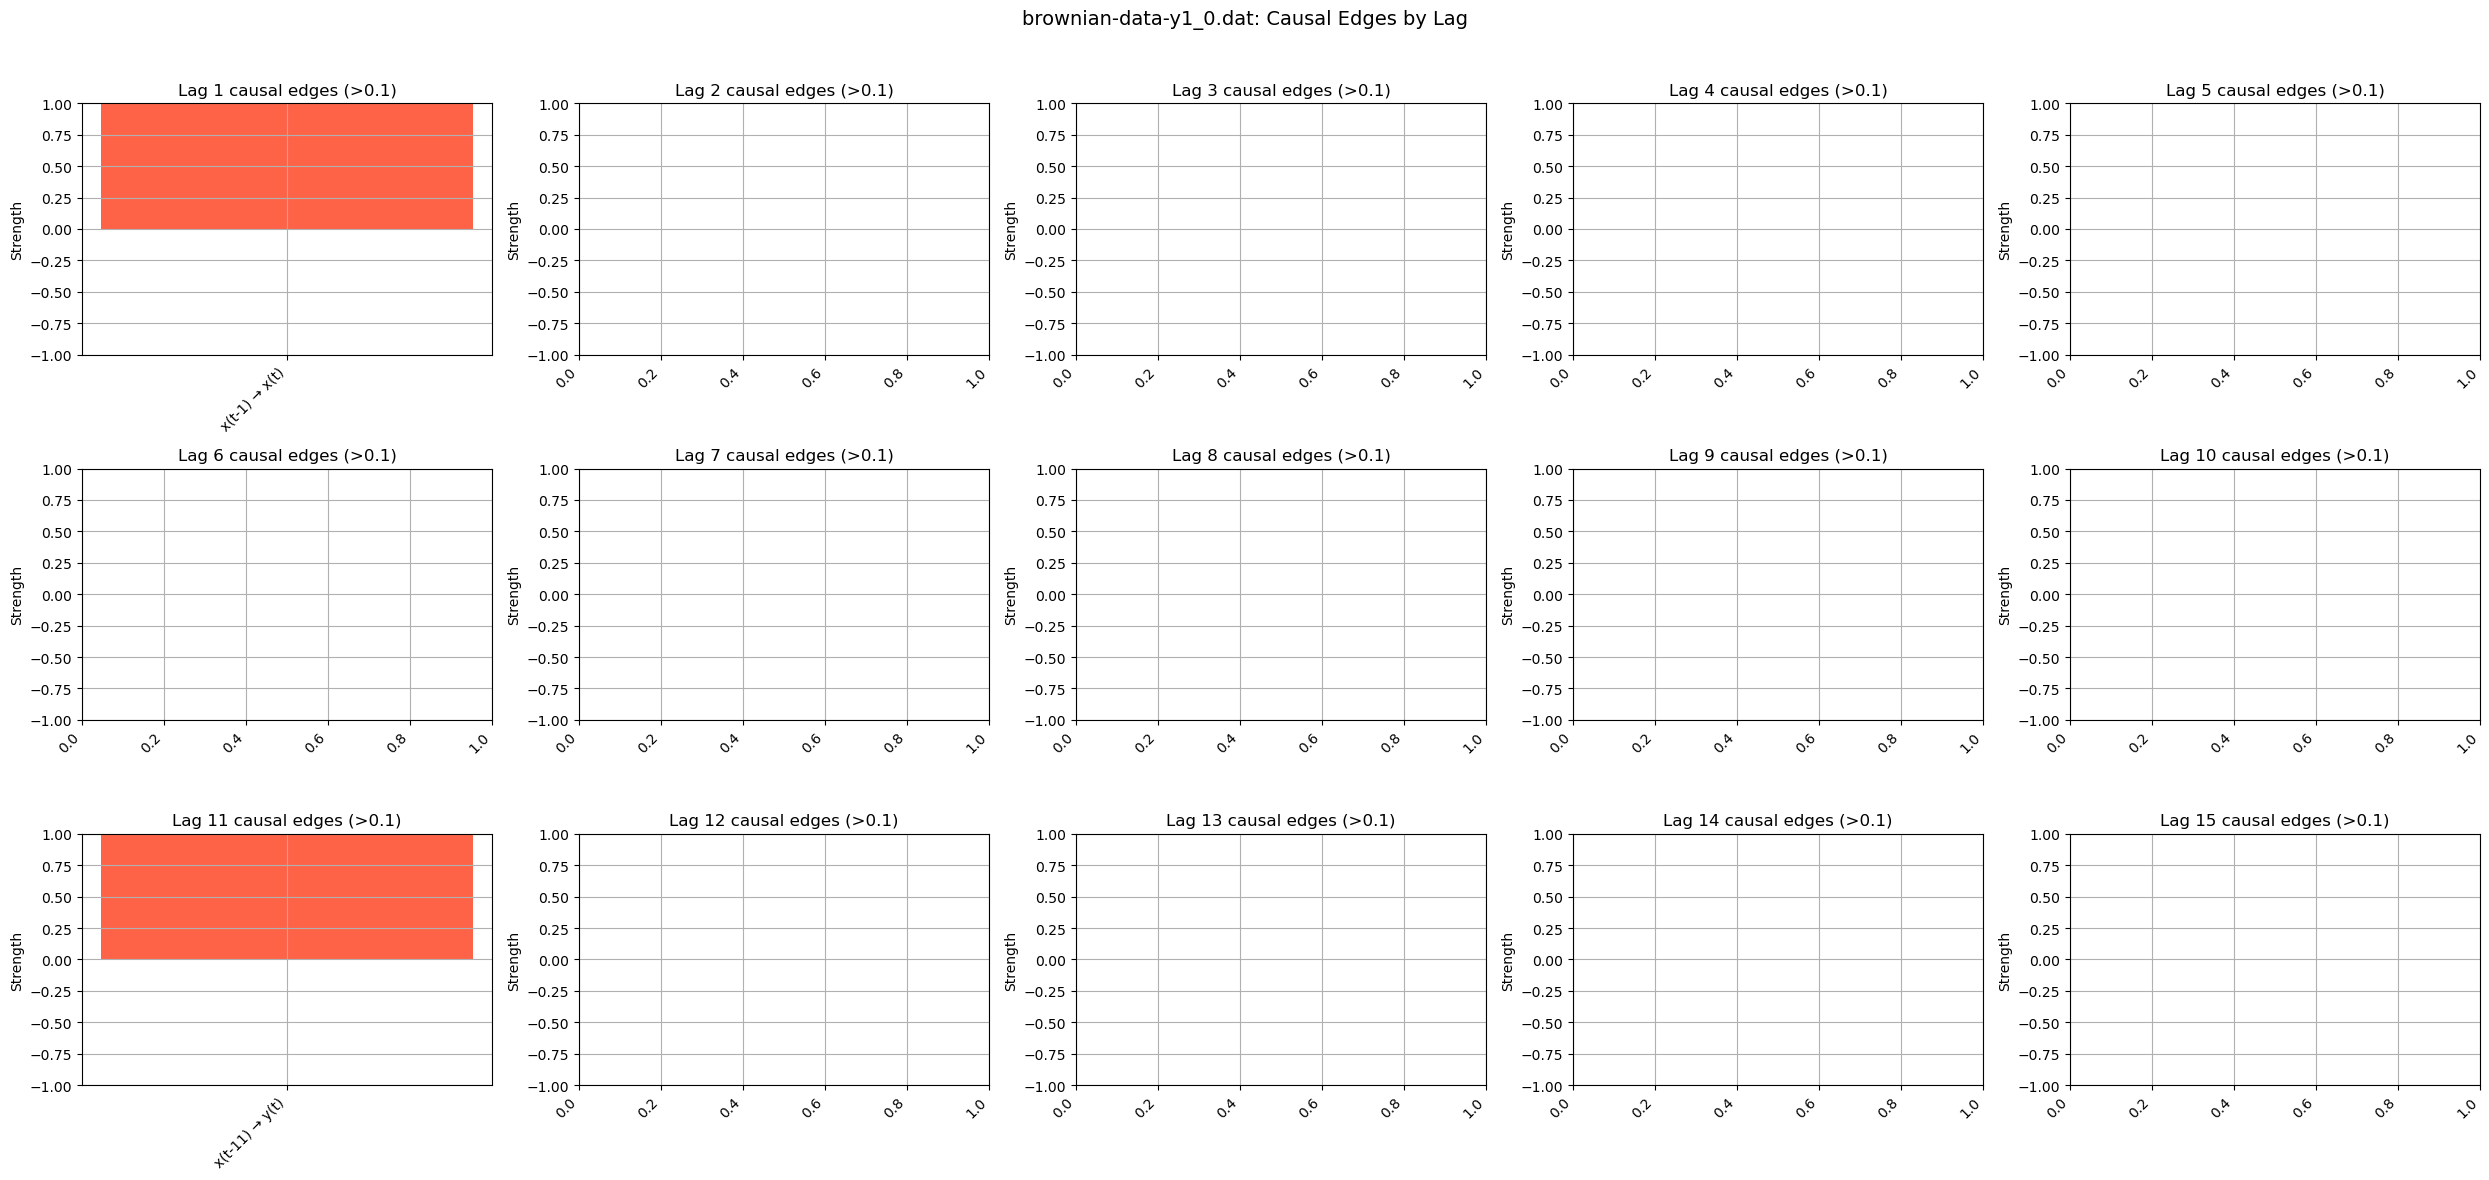


================== Analyzing brownian-data-y2_0.dat ==================

--- Causal Edges with Strength > 0.1 ---

Lag 0:
No strong causal edges.

Lag 1:
x(t-1) → x(t): strength = 1.002
y(t-1) → y(t): strength = 0.331

Lag 2:
y(t-2) → y(t): strength = 0.231

Lag 3:
y(t-3) → y(t): strength = 0.151

Lag 4:
y(t-4) → y(t): strength = 0.110

Lag 5:
No strong causal edges.

Lag 6:
No strong causal edges.

Lag 7:
No strong causal edges.

Lag 8:
No strong causal edges.

Lag 9:
No strong causal edges.

Lag 10:
No strong causal edges.

Lag 11:
x(t-11) → y(t): strength = -1.386

Lag 12:
x(t-12) → y(t): strength = 0.464

Lag 13:
x(t-13) → y(t): strength = 0.312

Lag 14:
x(t-14) → y(t): strength = 0.207

Lag 15:
x(t-15) → y(t): strength = 0.408


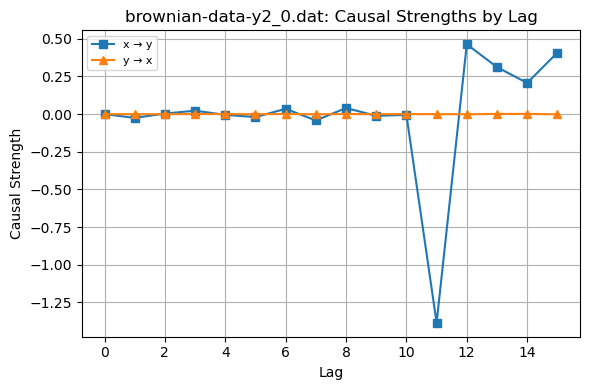

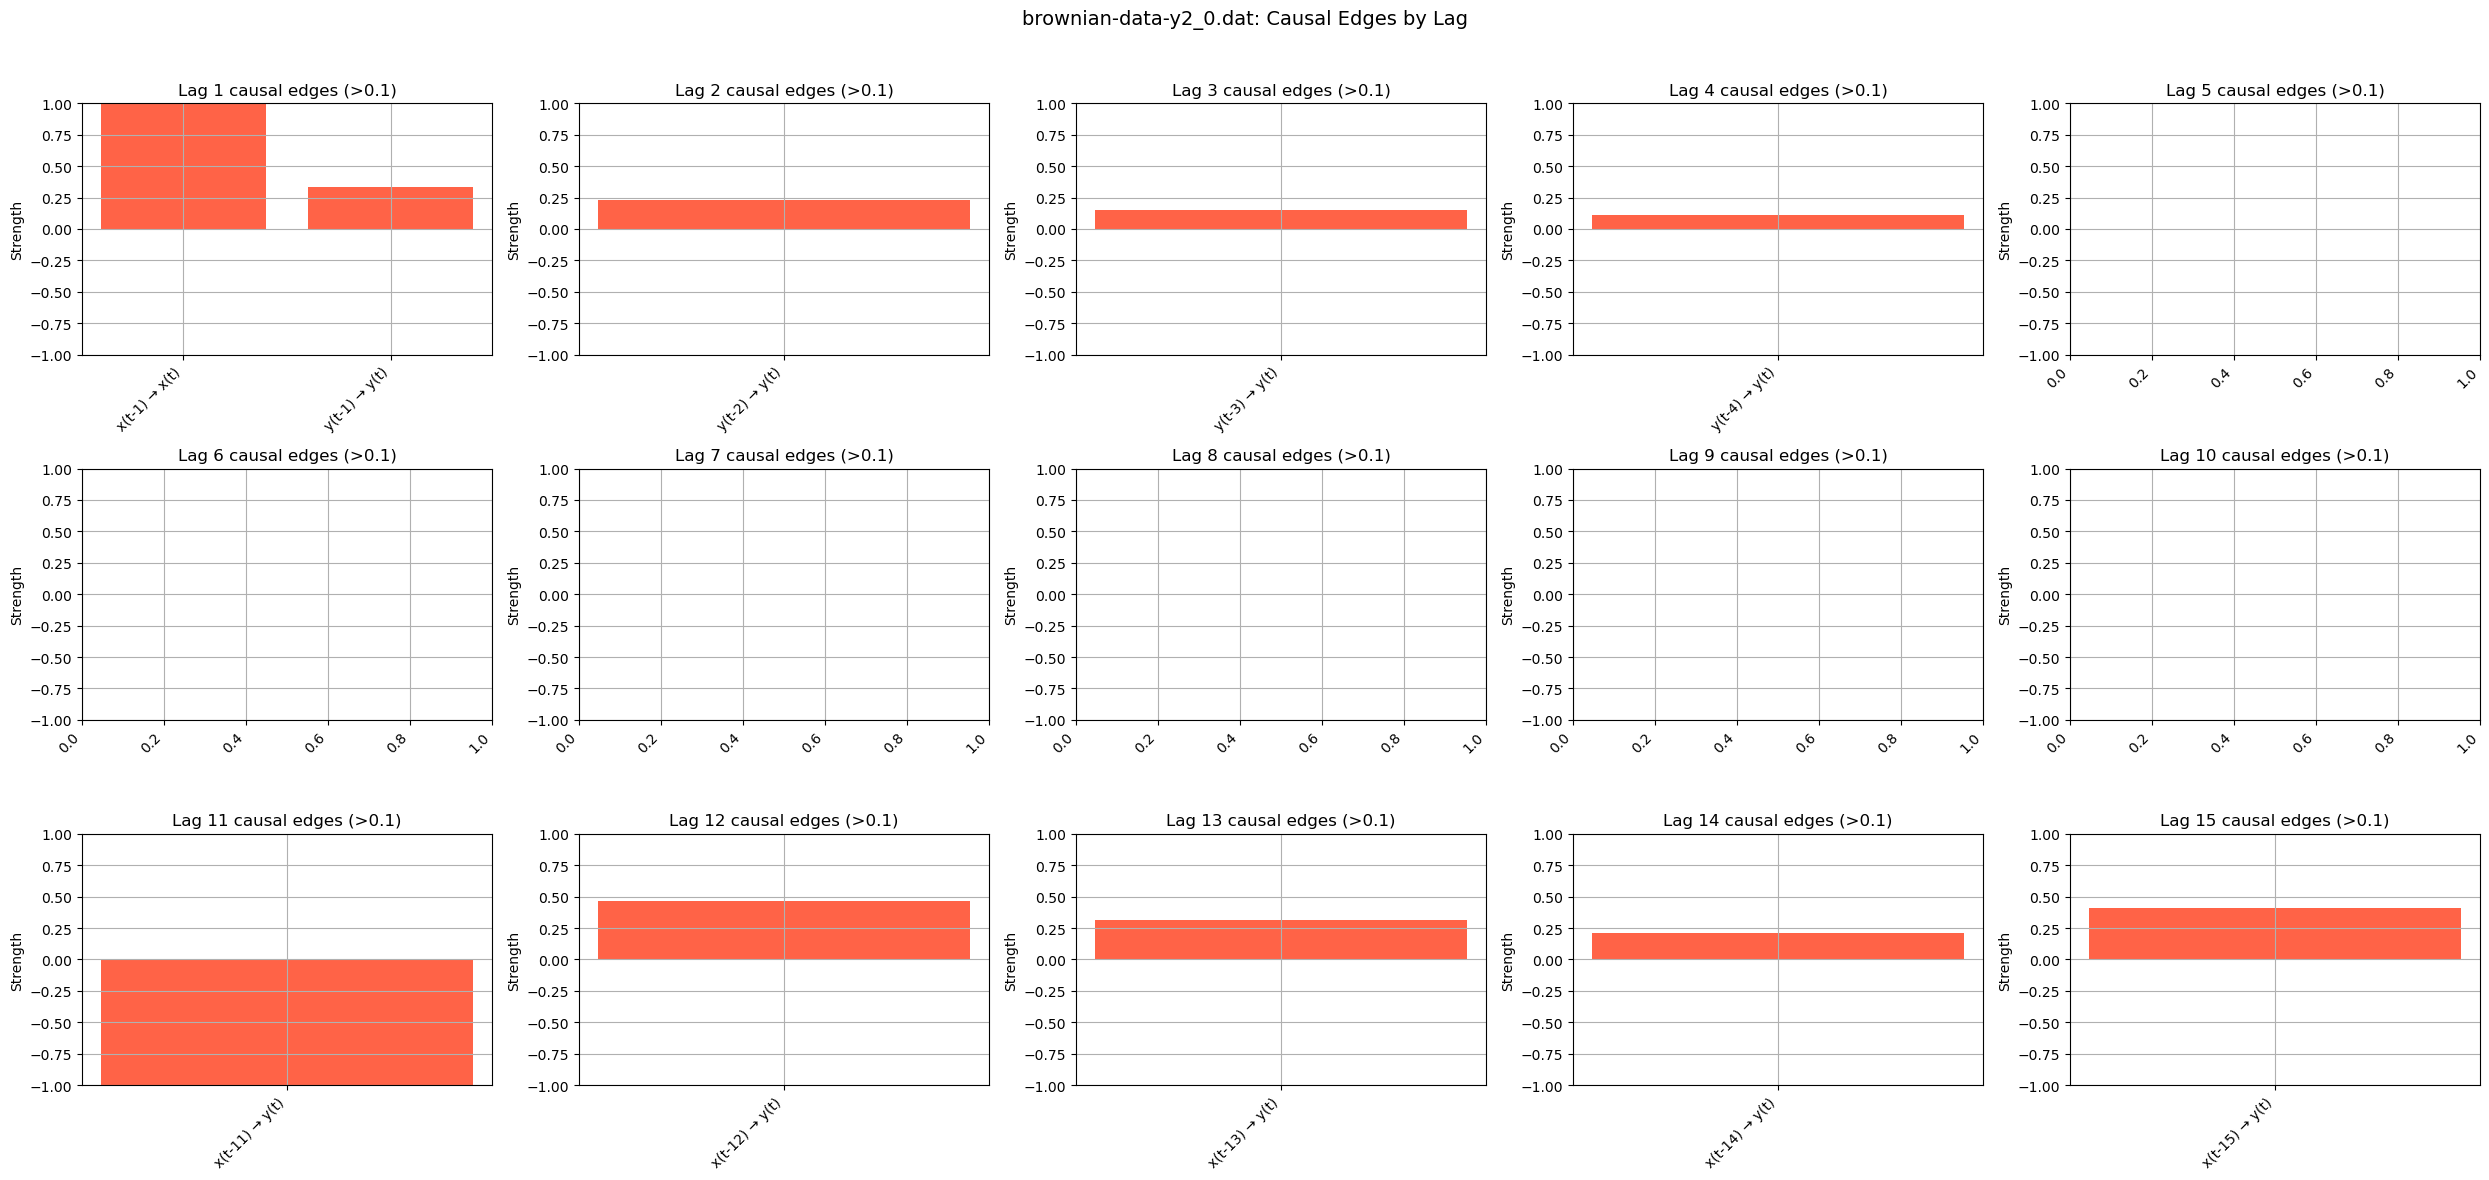


================== Analyzing brownian-data-y3_0.dat ==================

--- Causal Edges with Strength > 0.1 ---

Lag 0:
No strong causal edges.

Lag 1:
x(t-1) → x(t): strength = 1.002
y(t-1) → y(t): strength = 0.731

Lag 2:
y(t-2) → y(t): strength = 0.194

Lag 3:
No strong causal edges.

Lag 4:
No strong causal edges.

Lag 5:
No strong causal edges.

Lag 6:
No strong causal edges.

Lag 7:
No strong causal edges.

Lag 8:
No strong causal edges.

Lag 9:
No strong causal edges.

Lag 10:
No strong causal edges.

Lag 11:
x(t-11) → y(t): strength = -0.488

Lag 12:
x(t-12) → y(t): strength = 0.357

Lag 13:
No strong causal edges.

Lag 14:
No strong causal edges.

Lag 15:
No strong causal edges.


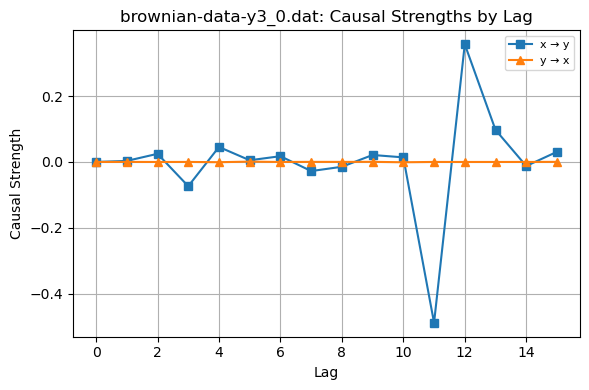

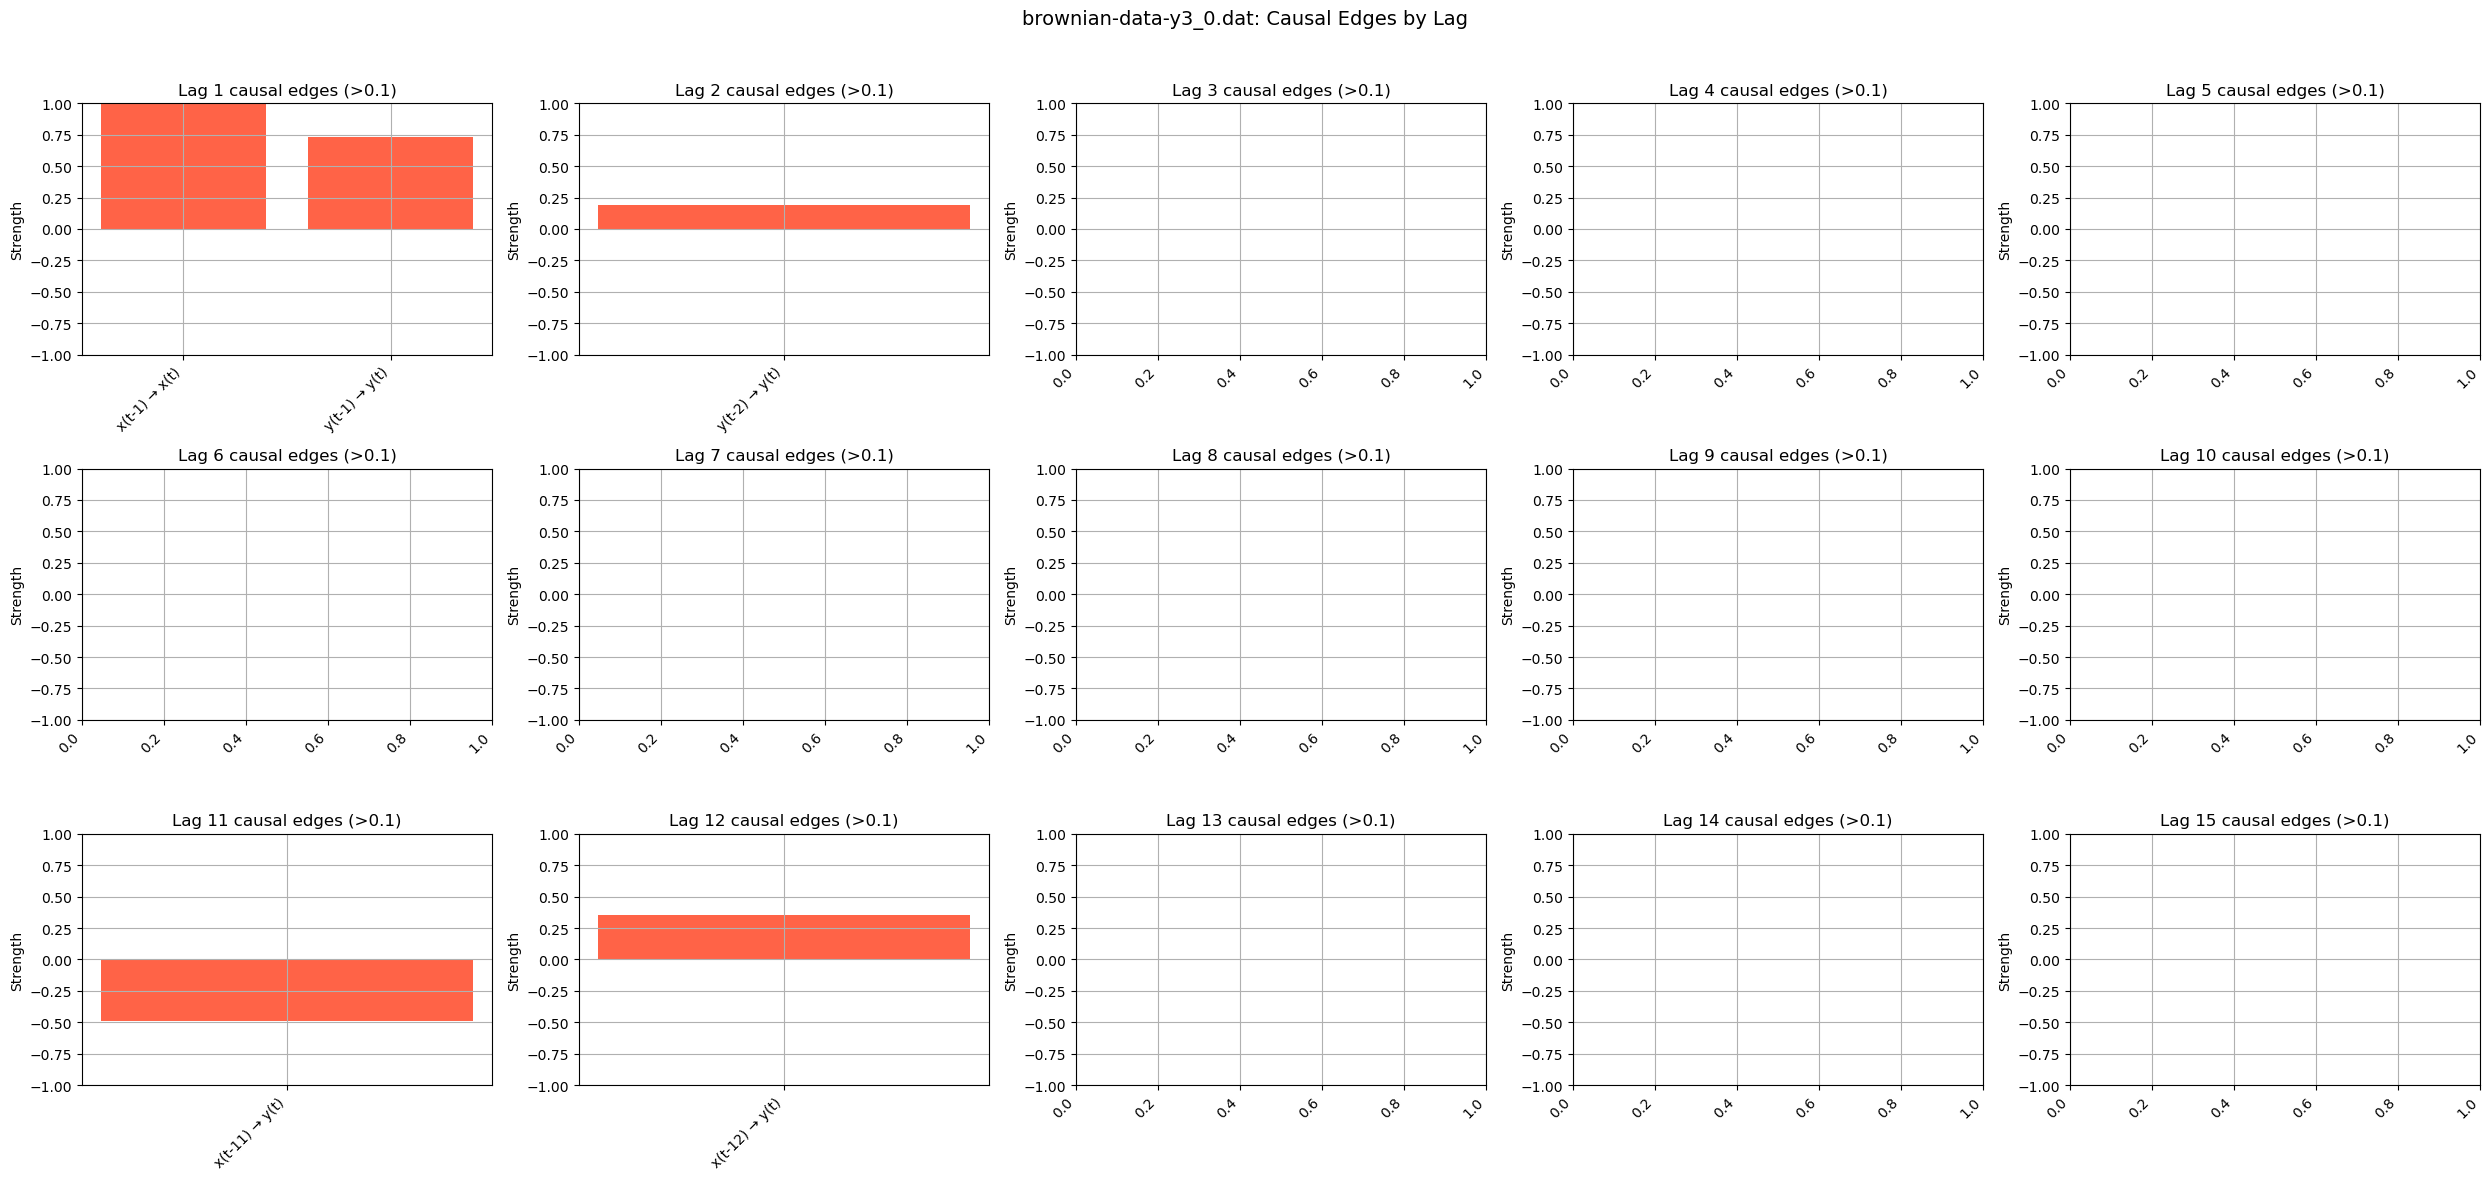

In [ ]:
# === Parameter settings ===
file_paths = [
    "./dataset/brownian-data-y1_0.dat",
    "./dataset/brownian-data-y2_0.dat",
    "./dataset/brownian-data-y3_0.dat"
]

var_names = ['x', 'y']
threshold = 0.1
max_lag = 15
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h']

for file_path in file_paths:
    print(f"\n================== Analyzing {os.path.basename(file_path)} ==================")

    # --- Load dataset ---
    """
    Load a .dat file, skipping the first column (time), and set column names.

    Args:
        file_path (str): Path to the .dat file.

    Returns:
        np.ndarray: Data array of shape (num_samples, num_vars)
    """
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    df = df.iloc[:, 1:]  # Skip time column
    df.columns = var_names
    data = df.values
    num_vars = data.shape[1]

    # --- Fit VARLiNGAM model ---
    """
    Fit a VARLiNGAM model to the dataset.

    Args:
        data (np.ndarray): Time series data array of shape (num_samples, num_vars)
        max_lag (int): Maximum lag order to consider

    Returns:
        VARLiNGAM: Fitted VARLiNGAM model
    """
    model = VARLiNGAM(lags=max_lag, criterion=None, prune=False, random_state=42)
    model.fit(data)

    # --- Extract causal strength matrices ---
    """
    Extract causal strength values from the VARLiNGAM adjacency matrices
    for each lag.

    Returns:
        dict: A dictionary mapping (cause_idx, effect_idx) -> list of strengths per lag
    """
    causal_strengths = {(i, j): [] for i in range(num_vars) for j in range(num_vars)}
    for lag, mat in enumerate(model.adjacency_matrices_):
        for i in range(num_vars):
            for j in range(num_vars):
                causal_strengths[(i, j)].append(mat[j, i])  # j ← i

    # --- Print strong causal edges at each lag ---
    """
    Print causal edges whose absolute strength exceeds the threshold
    for each lag from 0 to max_lag.

    Args:
        threshold (float): Minimum absolute strength to display an edge
    """
    print(f"\n--- Causal Edges with Strength > {threshold} ---")
    for lag in range(max_lag + 1):
        mat = model.adjacency_matrices_[lag]
        print(f"\nLag {lag}:")
        found = False
        for i in range(num_vars):
            for j in range(num_vars):
                strength = mat[j, i]
                if abs(strength) > threshold:
                    print(f"{var_names[i]}(t-{lag}) → {var_names[j]}(t): strength = {strength:.3f}")
                    found = True
        if not found:
            print("No strong causal edges.")

    # --- Plot causal strength curves ---
    """
    Plot causal strength curves from lag 0 to max_lag for all variable pairs.
    Self-causation edges are skipped.

    Args:
        causal_strengths (dict): Dictionary mapping (cause_idx, effect_idx) -> list of strengths per lag
    """
    plt.figure(figsize=(6, 4))
    for idx, ((cause, effect), values) in enumerate(causal_strengths.items()):
        if cause == effect:
            continue  # Skip self-causation
        plt.plot(range(max_lag + 1), values,
                 label=f'{var_names[cause]} → {var_names[effect]}',
                 marker=markers[idx % len(markers)])
    plt.title(f"{os.path.basename(file_path)}: Causal Strengths by Lag")
    plt.xlabel("Lag")
    plt.ylabel("Causal Strength")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    # --- Plot causal bar charts ---
    """
    Plot bar charts of causal strengths for each lag (1 to max_lag),
    only displaying edges whose absolute strength exceeds the threshold.

    Args:
        threshold (float): Minimum absolute strength to display an edge
    """
    n_rows, n_cols = 3, 5
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axs = axs.flatten()

    for lag in range(1, max_lag + 1):
        ax = axs[lag - 1]
        mat = model.adjacency_matrices_[lag]
        for i in range(num_vars):
            for j in range(num_vars):
                strength = mat[j, i]
                if abs(strength) > threshold:
                    label = f'{var_names[i]}(t-{lag}) → {var_names[j]}(t)'
                    ax.bar(label, strength, color='tomato')
        ax.set_title(f"Lag {lag} causal edges (>{threshold})")
        ax.set_ylabel("Strength")
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(-1, 1)
        ax.grid(True)

    # Remove unused subplots
    for i in range(max_lag, len(axs)):
        fig.delaxes(axs[i])

    fig.suptitle(f"{os.path.basename(file_path)}: Causal Edges by Lag", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
